In [1]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
data = pd.read_csv('ai4i2020.csv')

# Анализ данных и engineering

In [3]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Далее я подредактировал название столбцов, выбросил все ошибки которые являются случайными, обьеденил частоту обращения и крутящий момент в единую формулу мощности, обработал категориальный признак Type и удалил все ненужное.

In [4]:
data = data.rename(columns=lambda x: x.replace("[", "").replace("]", ""))
data = data[data['RNF'] == 0]
data['power'] = data['Rotational speed rpm']*data['Torque Nm'] / 9550
data = pd.concat(
    [data, pd.get_dummies(data['Type'], drop_first=True)],
    axis=1
)
data = data.drop(['UDI', 'Product ID', 'Torque Nm', 'Type' , 'M'], axis =1)

Здесь я создал по датафрейму для каждой из видов ошибок ( для просмотра статистик) а так же ползже удалил их из основного датасета.

In [5]:

fail_cols = ["TWF", "HDF", "PWF", "OSF", "RNF"]
no_fail_mask = (data[fail_cols].sum(axis=1) == 0)

data_TWF = data[(data["TWF"] == 1) | no_fail_mask].drop([ 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis =1).copy()
data_HDF = data[(data["HDF"] == 1) | no_fail_mask].drop([ 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis =1).copy()
data_PWF = data[(data["PWF"] == 1) | no_fail_mask].drop([ 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis =1).copy()
data_OSF = data[(data["OSF"] == 1) | no_fail_mask].drop([ 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis =1).copy()
data_RNF = data[(data["RNF"] == 1) | no_fail_mask].drop([ 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis =1).copy()

In [6]:
data = data.drop([ 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis =1)

In [7]:
data.head()

,Air temperature K,Process temperature K,Rotational speed rpm,Tool wear min,Machine failure,power,L
0,298.1,308.6,1551,0,0,6.951079,False
1,298.2,308.7,1408,3,0,6.826220,True
2,298.1,308.5,1498,5,0,7.748817,True
3,298.2,308.6,1433,7,0,5.927068,True
4,298.2,308.7,1408,9,0,5.897382,True


Разбиение на трейн и тест заранее, для избежания утечки в данных, а так же stratify для сохранения дисбаланса в классах.

In [8]:
x = data.drop(['Machine failure'], axis = 1)
y = data['Machine failure']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 45, stratify=y)

In [9]:
y_train

8468    0
4122    0
2071    0
576     0
8778    0
       ..
2245    0
2166    1
1744    0
3460    0
7727    0
Name: Machine failure, Length: 7984, dtype: int64

Здесь я объединил температуры воздух и станка по по формуле т_возд*к1 + т_станка*к2, где к1 и к2 подбираются циклом для увеличения модуля корреляции

In [10]:
warnings.filterwarnings('ignore')
min_k = 0
g = [0,0]
for j in range(-100, 100):
    for i in range(-100, 100):
        x_train['delta_temp'] = x_train['Air temperature K'] * j + x_train['Process temperature K'] * i
        if  abs(x_train['delta_temp'].corr(y_train)) > min_k:
            min_k = x_train['delta_temp'].corr(y_train)
            g = [j, i]
x_train['delta_temp'] = x_train['Air temperature K'] * g[0] + x_train['Process temperature K'] * g[1]
x_test['delta_temp'] = x_test['Air temperature K'] * g[0] + x_test['Process temperature K'] * g[1]

x_train = x_train.drop(['Air temperature K'], axis = 1)
x_test = x_test.drop(['Air temperature K'], axis = 1)

По  факту деревьям стандартизация не нужна, но если вы захотите обучить нейронку то это поможет

In [11]:

scaler = StandardScaler()

x_train = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns=x_train.columns,
    index=x_train.index
)

x_test = pd.DataFrame(
    scaler.transform(x_test),
    columns=x_test.columns,
    index=x_test.index
)


Корреляционная матрица для таблиц с каждой из ошибок а так же с основным датасетом(Можно запускать много раз во время работы для отслеживания процесса)

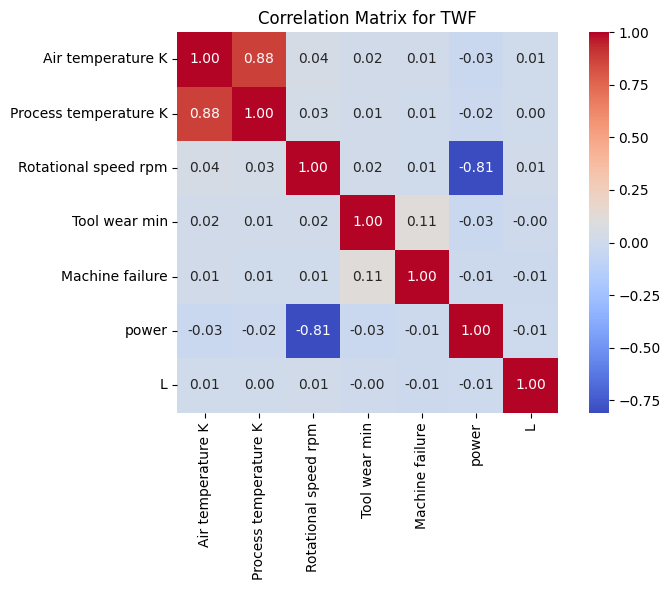

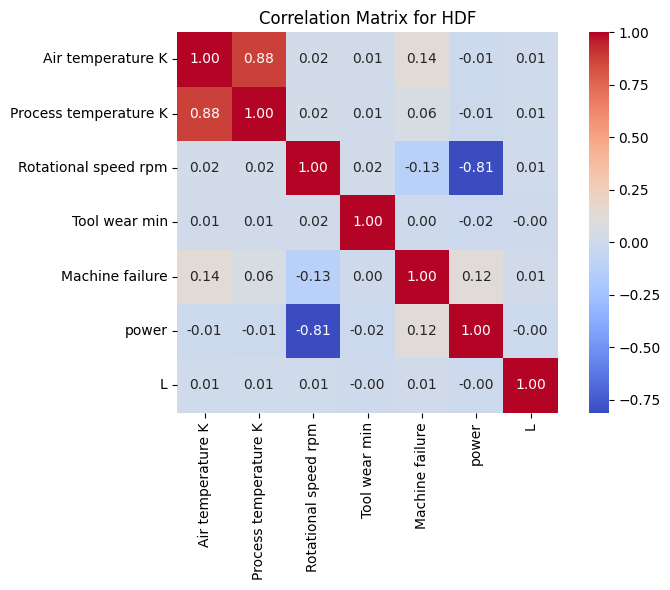

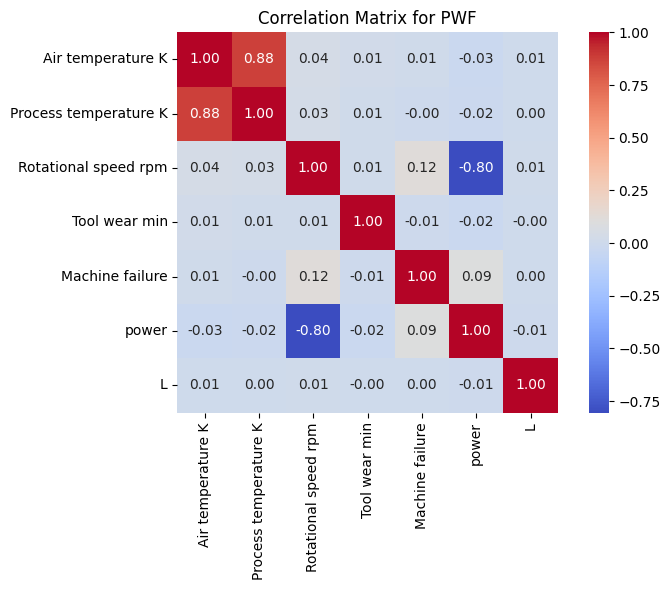

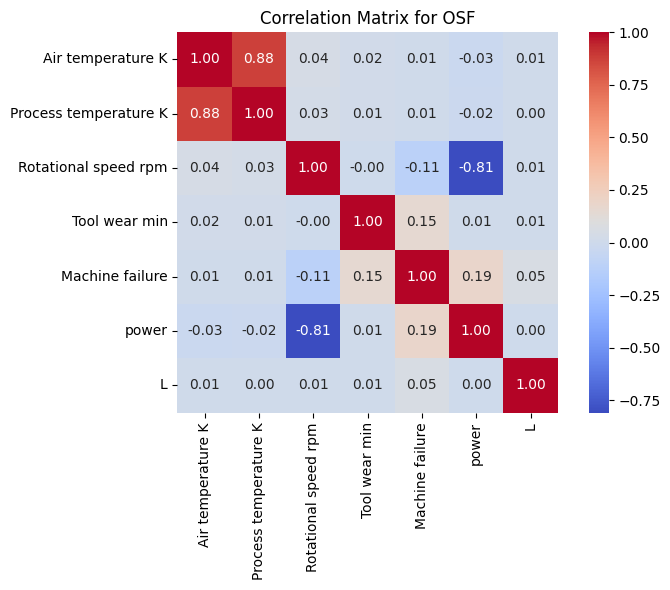

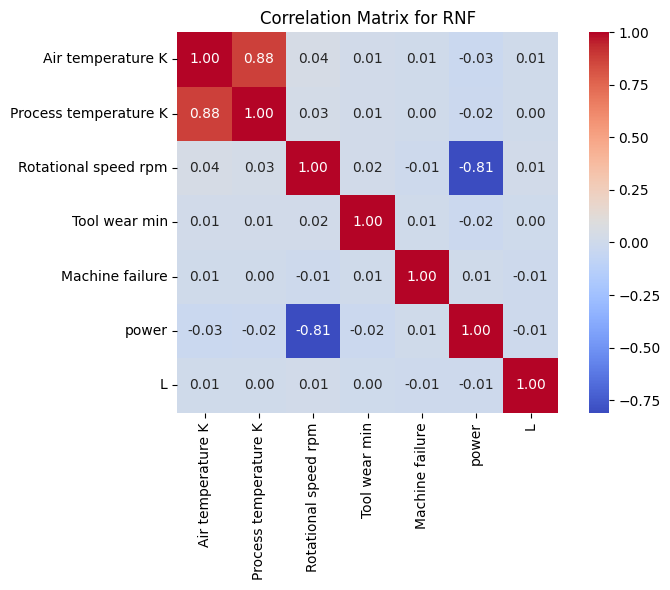

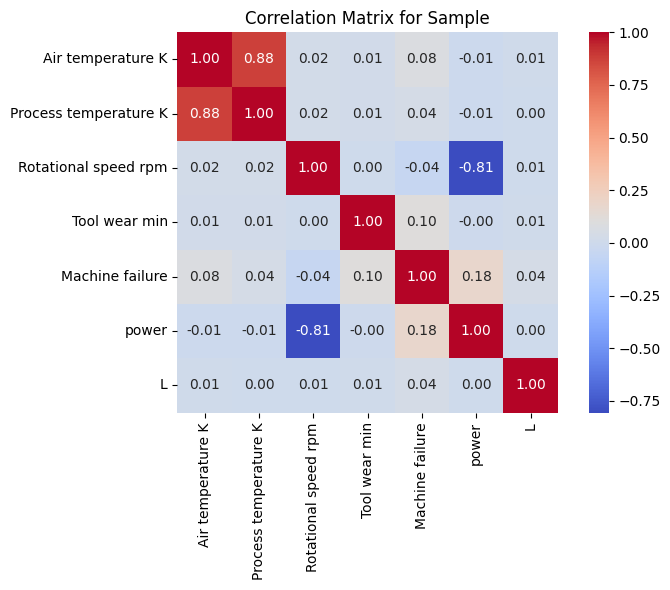

In [12]:

datasets = {
    "TWF": data_TWF,
    "HDF": data_HDF,
    "PWF": data_PWF,
    "OSF": data_OSF,
    "RNF": data_RNF,
    "Sample": data
}

for name, df in datasets.items():
    plt.figure(figsize=(8,6))
    
    corr = df.corr(numeric_only=True)   # на случай, если есть категориальные
    
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    
    plt.title(f"Correlation Matrix for {name}")
    plt.tight_layout()
    plt.show()


Распределение всех признаков из основной дата(Можно запускать много раз во время работы для отслеживания процесса)

In [13]:
'''
n_cols = 4  
cols = data.columns
n_rows = math.ceil(len(cols) / n_cols)

plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    
    if data[col].dtype == 'object' or data[col].nunique() < 8:
        data[col].value_counts().plot(kind='bar')
        plt.ylabel("Count")
    else:
        data[col].plot(kind='hist', bins=30)
        plt.ylabel("Frequency")
    
    plt.title(f"{col}")
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
'''

'\nn_cols = 4  \ncols = data.columns\nn_rows = math.ceil(len(cols) / n_cols)\n\nplt.figure(figsize=(n_cols * 4, n_rows * 3))\n\nfor i, col in enumerate(cols, 1):\n    plt.subplot(n_rows, n_cols, i)\n    \n    if data[col].dtype == \'object\' or data[col].nunique() < 8:\n        data[col].value_counts().plot(kind=\'bar\')\n        plt.ylabel("Count")\n    else:\n        data[col].plot(kind=\'hist\', bins=30)\n        plt.ylabel("Frequency")\n    \n    plt.title(f"{col}")\n    plt.grid(axis=\'y\', linestyle=\'--\', alpha=0.5)\n\nplt.tight_layout()\nplt.show()\n'

Некоторые графики для новой переменной delta_temp

In [14]:
'''
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Scatter с джиттером
y_jitter = data['Machine failure'] + np.random.normal(0, 0.02, len(data))
axes[0, 0].scatter(data['delta_temp'], y_jitter, alpha=0.3, s=10)
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_yticklabels(['No Failure', 'Failure'])
axes[0, 0].set_xlabel('Delta Temperature')
axes[0, 0].set_ylabel('Machine Failure')
axes[0, 0].set_title('Точечный график')
axes[0, 0].grid(True, alpha=0.3)

# 2. Гистограммы распределений
delta_temp_failure = data[data['Machine failure'] == 1]['delta_temp']
delta_temp_no_failure = data[data['Machine failure'] == 0]['delta_temp']
axes[0, 1].hist(delta_temp_no_failure, bins=30, alpha=0.5, label='No Failure', density=True)
axes[0, 1].hist(delta_temp_failure, bins=30, alpha=0.5, label='Failure', density=True)
axes[0, 1].set_xlabel('Delta Temperature')
axes[0, 1].set_ylabel('Плотность')
axes[0, 1].set_title('Распределения по классам')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot
axes[1, 0].boxplot([delta_temp_no_failure, delta_temp_failure], 
                   labels=['No Failure', 'Failure'])
axes[1, 0].set_xlabel('Machine Failure')
axes[1, 0].set_ylabel('Delta Temperature')
axes[1, 0].set_title('Box plot сравнения')
axes[1, 0].grid(True, alpha=0.3)

# 4. График долей по бинам
if 'delta_temp_bin' in data.columns:
    failure_rate = data.groupby('delta_temp_bin')['Machine failure'].mean().reset_index()
    failure_rate['bin_center'] = failure_rate['delta_temp_bin'].apply(lambda x: x.mid)
    axes[1, 1].plot(failure_rate['bin_center'], failure_rate['Machine failure'], 
                    marker='o', linewidth=2)
    axes[1, 1].set_xlabel('Delta Temperature')
    axes[1, 1].set_ylabel('Доля отказов')
    axes[1, 1].set_title('Частота отказов по бинам')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
'''

"\nfig, axes = plt.subplots(2, 2, figsize=(15, 10))\n\n# 1. Scatter с джиттером\ny_jitter = data['Machine failure'] + np.random.normal(0, 0.02, len(data))\naxes[0, 0].scatter(data['delta_temp'], y_jitter, alpha=0.3, s=10)\naxes[0, 0].set_yticks([0, 1])\naxes[0, 0].set_yticklabels(['No Failure', 'Failure'])\naxes[0, 0].set_xlabel('Delta Temperature')\naxes[0, 0].set_ylabel('Machine Failure')\naxes[0, 0].set_title('Точечный график')\naxes[0, 0].grid(True, alpha=0.3)\n\n# 2. Гистограммы распределений\ndelta_temp_failure = data[data['Machine failure'] == 1]['delta_temp']\ndelta_temp_no_failure = data[data['Machine failure'] == 0]['delta_temp']\naxes[0, 1].hist(delta_temp_no_failure, bins=30, alpha=0.5, label='No Failure', density=True)\naxes[0, 1].hist(delta_temp_failure, bins=30, alpha=0.5, label='Failure', density=True)\naxes[0, 1].set_xlabel('Delta Temperature')\naxes[0, 1].set_ylabel('Плотность')\naxes[0, 1].set_title('Распределения по классам')\naxes[0, 1].legend()\naxes[0, 1].grid(Tr

# Модель

Функция для основных метрик

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_classification_metrics(y_test, y_pred):
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:", round(recall_score(y_test, y_pred), 4))
    print("F1-score:", round(f1_score(y_test, y_pred), 4))

Отправное решение

In [16]:
model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print_classification_metrics(y_test, y_pred)

Accuracy: 0.9855
Precision: 0.8
Recall: 0.7647
F1-score: 0.782


Выбор лучшей модели

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ---------------- DummyClassifier ----------------
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(x_train, y_train)
y_pred = dummy.predict(x_test)
print("DummyClassifier")
print_classification_metrics(y_test, y_pred)
print("-" * 40)

# ---------------- Logistic Regression ----------------
logreg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print("Logistic Regression (balanced)")
print_classification_metrics(y_test, y_pred)
print("-" * 40)

# ---------------- Random Forest ----------------
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("Random Forest (balanced)")
print_classification_metrics(y_test, y_pred)
print("-" * 40)

# ---------------- XGBoost ----------------
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=neg / pos,
    random_state=42
)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print("XGBoost (simple)")
print_classification_metrics(y_test, y_pred)
print("-" * 40)


DummyClassifier
Accuracy: 0.9659
Precision: 0.0
Recall: 0.0
F1-score: 0.0
----------------------------------------
Logistic Regression (balanced)
Accuracy: 0.7792
Precision: 0.1057
Recall: 0.7353
F1-score: 0.1848
----------------------------------------
Random Forest (balanced)
Accuracy: 0.9915
Precision: 0.9811
Recall: 0.7647
F1-score: 0.8595
----------------------------------------
XGBoost (simple)
Accuracy: 0.977
Precision: 0.6279
Recall: 0.7941
F1-score: 0.7013
----------------------------------------


In [18]:
rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# ---------------- пространство гиперпараметров ----------------
param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

# ---------------- Randomized Search ----------------
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,              # оптимальный баланс время/качество
    scoring="f1",           # КЛЮЧЕВО при дисбалансе
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

search.fit(x_train, y_train)

# ---------------- лучшая модель ----------------
best_rf = search.best_estimator_

print("Лучшие гиперпараметры:")
print(search.best_params_)
print("-" * 40)

# ---------------- оценка на test ----------------
y_pred = best_rf.predict(x_test)

print("Random Forest (best model)")
print_classification_metrics(y_test, y_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие гиперпараметры:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
----------------------------------------
Random Forest (best model)
Accuracy: 0.9885
Precision: 0.8462
Recall: 0.8088
F1-score: 0.8271
